# **Parameter estimation from protected area**



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, Markdown
from scipy.optimize import minimize
import pandas as pd
from matplotlib.collections import LineCollection

In [2]:
def simulate_system(T, Dt, Ntraj, params, init_cond, DB):

    rhoA, KA, mA, mJ, rJ, sA, sJ = params[0], params[1], params[2], params[3], params[4], params[5], params[6]
    N = int(T/Dt)
    # Generating SDEs traject
    B = np.zeros(shape=(2, N+1, Ntraj))
    B[0,0,:] = init_cond[0]*np.ones(Ntraj)
    B[1,0,:] = init_cond[1]*np.ones(Ntraj)
    
    for n in range(N):
        # Compute juveniles biomass
        B[0, n+1,:] = B[0, n,:] + rJ*(1-np.min(np.vstack((B[0,n,:]+B[1,n,:],KA*np.ones_like(B[0,n,:]))),axis=0)/KA) * B[1,n,:] * Dt - (rhoA +mJ) *B[0, n,:] * Dt + sJ *B[0, n,:] * DB[0, n, : ]*np.sqrt(Dt)
        # B[0, n+1,:] = B[0, n,:] + rJ*(1-(B[0,n,:]+B[1,n,:])/KA) * B[1,n,:] * Dt - (rhoA +mJ) *B[0, n,:] * Dt + sJ *B[0, n,:] * DB[0, n, : ]*np.sqrt(Dt)
        # Compute adults biomass
        B[1, n+1,:] = B[1, n,:] + rhoA * B[0,n,:] * Dt - mA *B[1, n,:] * Dt + sA *B[1, n,:] * DB[1, n, : ]*np.sqrt(Dt)

    return B[0, :,:] + B[1, :,:]

def visualization(T, Dt, trajectories, params, init_cond, past_years = 0):

    N = int((T+past_years)/Dt)
    # Generation of Brownian motions
    DB = np.random.standard_normal(size=(2, N+1, trajectories))

    B = simulate_system(T+past_years, Dt, trajectories, params, init_cond, DB)
    
    q1 = np.quantile(B, 0.25, axis=1)
    q3 = np.quantile(B, 0.75, axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
    fig.suptitle('Ajuste')
    
    t = np.linspace(0, T + past_years, int((T+past_years) * N_per_year) + 1) 
    
    axs[0].plot(t, B, color='gray', alpha=0.05)
    axs[0].fill_between(t, q1, q3, color='blue', label='IQR (Q1–Q3)')
    axs[0].plot(t, B.mean(axis = 1), color='blue', label='Promedio')
    axs[0].plot(t[360*past_years::90], av_biomass, 'ro', label='Biomasa total observada (promedio)')
    axs[0].errorbar(t[360*past_years::90], av_biomass, yerr=2*st_dev_biomass, fmt='none', ecolor='k', alpha=0.4, capsize=4, label='±2 std')
    axs[0].set_xlabel('Tiempo')
    axs[0].set_ylabel('Biomasa g/m^2')
    axs[0].grid(True)
    axs[0].legend()
    
    axs[1].fill_between(t, q1, q3, color='blue', label='IQR (Q1–Q3)')
    axs[1].plot(t[360*past_years::90], av_biomass, 'ro', label='Biomasa total observada (promedio)')
    axs[1].errorbar(t[360*past_years::90], av_biomass, yerr=2*st_dev_biomass, fmt='none', ecolor='k', alpha=0.4, capsize=4, label='±2 std')
    axs[1].set_xlabel('Tiempo')
    axs[1].set_ylabel('Biomasa g/m^2')
    axs[1].grid(True)
    axs[1].legend()

## **Stochastic model without extraction or rare events**

\begin{align*}
dJ_t&= \left(r_J \left(1-\frac{A_t+J_t}{K_A}\right)A_t - (\rho_A + m_J)J_t\right)dt + \sigma_J J_t dW^{(J)}_t\\
dA_t&= \left(\rho_A J_t - m_A A_t\right)dt + \sigma_A A_t dW^{(A)}_t,
\end{align*}
with $\rho_A = 1$.

### *Load approximated data*

In [3]:
# Loading data
df_loaded = pd.read_csv('biomass_data.csv')

av_biomass = df_loaded['av_biomass'].values
st_dev_biomass = df_loaded['st_dev_biomass'].values



## *From loaded data, we estimate carrying capacity and initial conditions* ##

**Note:** Here we assume that the adult proportion is 88% and that all juveniles mature into adults within one year:

$$p_A = 0.88$$
$$A_t = p_A (J_t+A_t)$$
$$\rho_A = 1$$
$$r_J = 35.5$$

We will assume that, of the total population variability, 40% corresponds to juvenile variability and 60% to adult variability, as calculated previously:
$$\sigma_J^2 = 0.4 \sigma^2,\qquad \sigma_A^2 = 0.6 \sigma^2,\qquad \sigma^2 = 0.15.$$

\begin{align*}
dJ_t&= \left(r_J \left(1-\frac{A_t+J_t}{K_A}\right)A_t - (\rho_A + m_J)J_t\right)dt + \sqrt{0.4} \sigma J_t dW^{(J)}_t\\
dA_t&= \left(\rho_A J_t - m_A A_t\right)dt + \sqrt{0.6} \sigma A_t dW^{(A)}_t.
\end{align*}

We then aim to adjust $m_A$ and $m_J$ to find the values that best replicate the intervals reported in the literature for the reserve area. To do this, we consider the following minimization problem:

\begin{equation*}
(\hat{m_J}, \hat{m_A}) = \underset{m_J>\ m_A > 0}{\operatorname{argmin}} \sum_{t_{\text{obs}}} \left\{\left(\mathtt{st\_dev\_biomass}[t_{\text{obs}}]-\sqrt{\mathbb{V}[J_{tobs}^{m_J, m_A}+A_{tobs}^{m_J, m_A}]}\right)^2 + \left(\mathtt{av\_biomass}[t_{\text{obs}}]-\mathbb{E}[J_{tobs}^{m_J, m_A}+A_{tobs}^{m_J, m_A}]\right)^2\right\}
\end{equation*}


In [ ]:
pA = 0.88 
rhoA = 1
rJ = 35.5
s2 = 0.15
sA = np.sqrt(s2*0.6)
sJ = np.sqrt(s2*0.4)

# Capacidad de carga se define como el maximo de los promedios
id_KA = np.argmax(av_biomass)
KA = av_biomass[id_KA]#float(2*st_dev_biomass[id_KA] + av_biomass[id_KA])

print(f"Capacidad de carga estimada = {KA}")

In [5]:
#t0 = summer 2006
# t = [Sum06,Aut06,Win06,Spr06,Sum07,Aut07,Win07,Spr07,Sum08]
T = 2
dt = 0.25 # cada tres meses

N_per_year = 360
t = np.linspace(0, T, int(T * N_per_year) + 1) 
Dt = t[1]

nb_guess = 10

low_b = np.array([1.0, 1.0]) # mA, mJ
high_b = np.array([8.0, 30.0])

bounds = [(0, None),  # mA >= 0
          (0, None)] # mJ >= 0

n_trajectorias_for_min = 10000

In [6]:
# Defining cost function
def cost_function(params, st_dev_obs, mean_obs, rhoA, KA, rJ, sA, sJ, init_cond, T, Dt, Ntraj, past_years, DB):
    mA, mJ = params
    
    B = simulate_system(T + past_years, Dt, Ntraj, [rhoA, KA, mA, mJ, rJ, sA, sJ], init_cond, DB)[past_years*360::90]
    std_sim = np.sqrt(B.var(axis=1))
    mean_sim = B.mean(axis=1)
    
    tt = np.linspace(0, T, 9) 
    weight_vector_av = np.asarray([1,1,1,1, 0.05, 0.05, 1, 1, 1])
    weight_vector_sd = weight_vector_av

    penalization1 = 1e5*( mA < 0)*( mJ < 0 )# cuando sea negativo
    penalization2 = 1e2 * max(mA - mJ, 0)**2# cuando mA>mJ

    return np.sum(np.concatenate(( weight_vector_sd*(std_sim - st_dev_obs)/KA, weight_vector_av*(mean_sim - mean_obs)/KA))**2) + penalization1+penalization2
# np.exp(tt)*

# Generate initial guesses uniformly within domain
initial_guess = np.random.uniform(low=low_b, high=high_b, size=(nb_guess,2))

### *OPCION 2: Optimizamos sobre (mJ, mA) pero empezando 2 años antes* ###


Condición inicial J_0 = 5740.062857142857, A_0 = 42093.794285714284
Condición inicial J_0 = 5664.48, A_0 = 41539.52
Optimization terminated successfully.
         Current function value: 0.007355
         Iterations: 88
         Function evaluations: 185
[6.50327790e-01 1.12816836e+01 7.35482920e-03]
Optimization terminated successfully.
         Current function value: 0.007355
         Iterations: 109
         Function evaluations: 223
[6.50327786e-01 1.12816837e+01 7.35482920e-03]
Optimization terminated successfully.
         Current function value: 0.007355
         Iterations: 104
         Function evaluations: 215
[6.50327797e-01 1.12816835e+01 7.35482920e-03]
Optimization terminated successfully.
         Current function value: 0.007355
         Iterations: 100
         Function evaluations: 207
[6.50327775e-01 1.12816839e+01 7.35482920e-03]
Optimization terminated successfully.
         Current function value: 0.007355
         Iterations: 103
         Function evaluations: 2

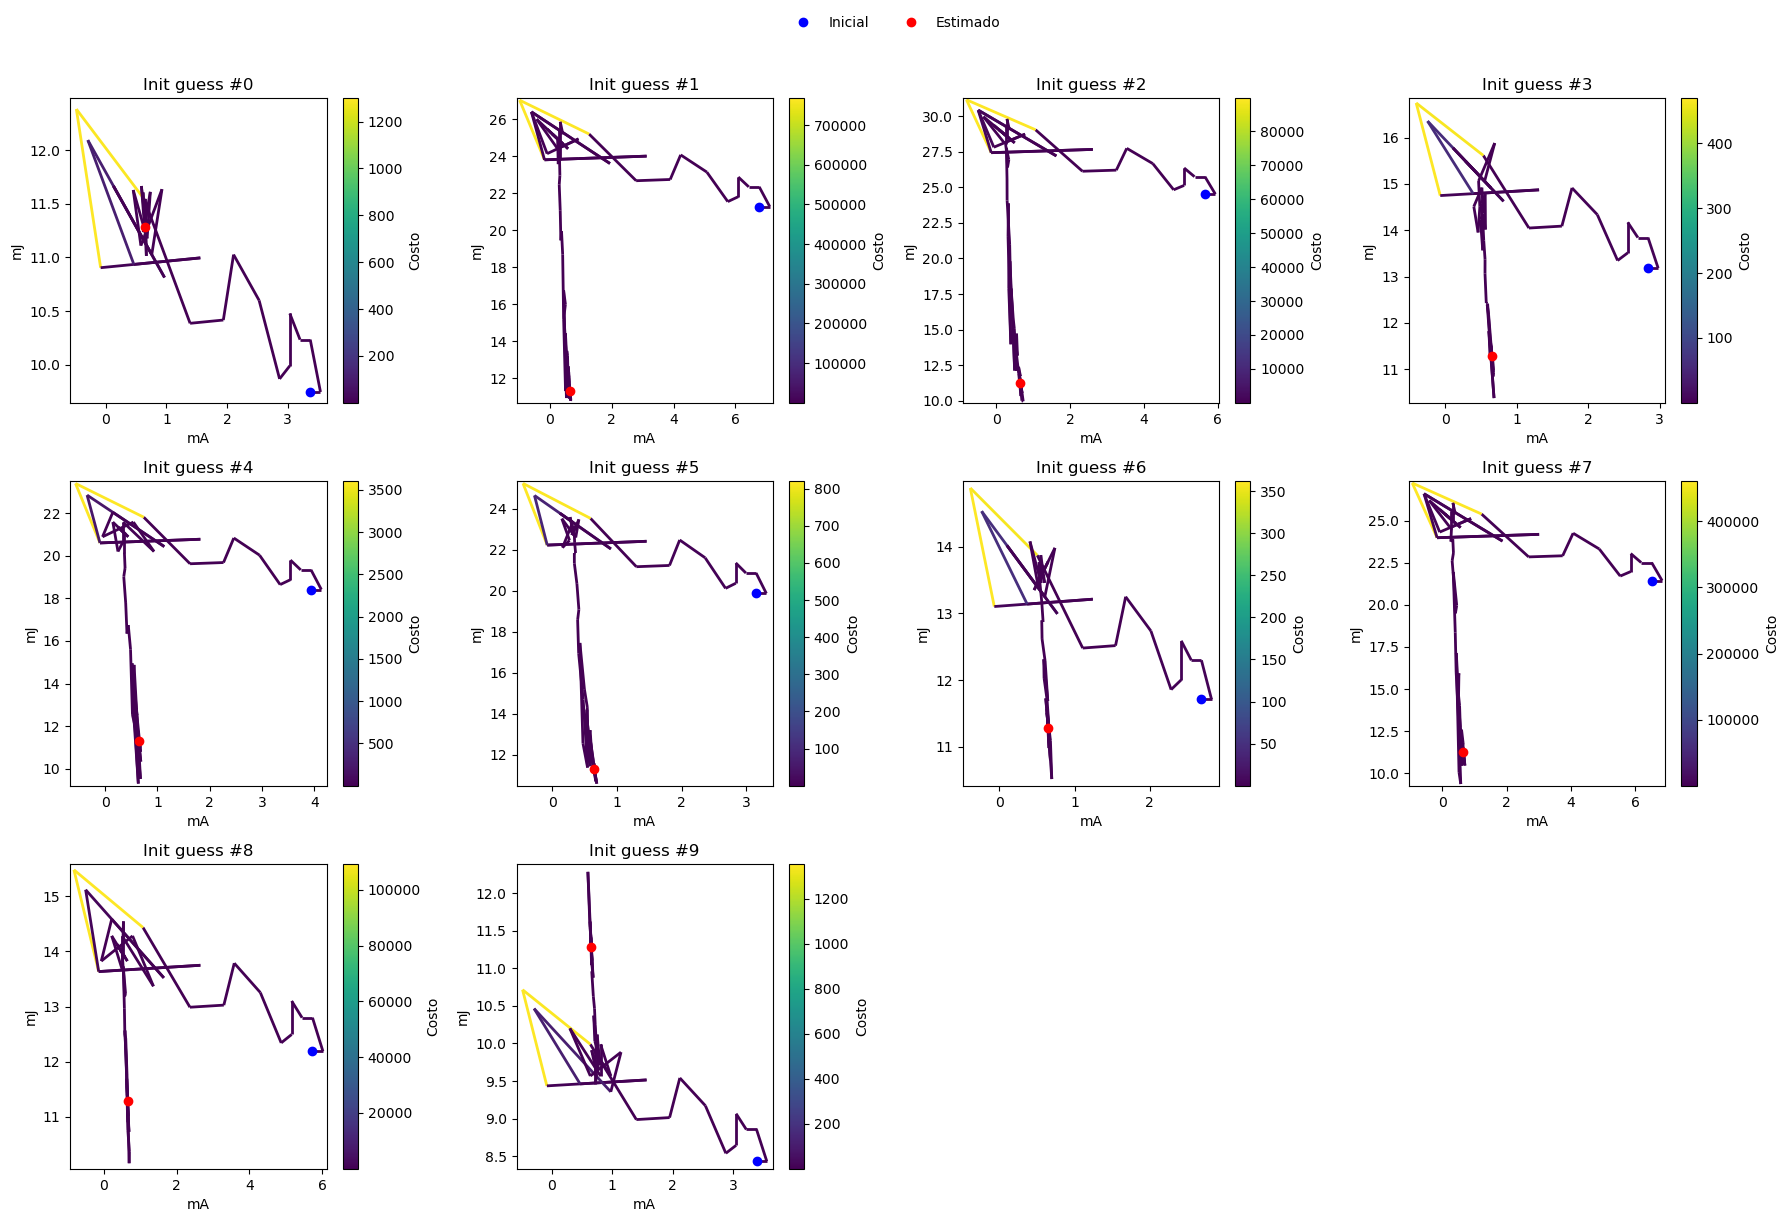

         mA         mJ     costo
0  0.650328  11.281684  0.007355
1  0.650328  11.281684  0.007355
2  0.650328  11.281683  0.007355
3  0.650328  11.281684  0.007355
4  0.650328  11.281683  0.007355
5  0.650328  11.281684  0.007355
6  0.650328  11.281683  0.007355
7  0.650328  11.281683  0.007355
8  0.650328  11.281683  0.007355
9  0.650328  11.281684  0.007355


In [7]:
mean_aux = (np.sum(av_biomass) - np.sum(av_biomass[4:6]))/(len(av_biomass)-2)
init_cond2 = [mean_aux*(1-pA), mean_aux*pA]
print(f"Initial condition J_0 = {init_cond2[0]}, A_0 = {init_cond2[1]}")

years_before = 5

# Defining Brownian motions
N = int((T+years_before)/Dt)
DB = np.random.standard_normal(size=(2, N+1, n_trajectorias_for_min))

estimates2 = np.zeros((nb_guess, 3))

ncols = int(np.ceil(np.sqrt(nb_guess)))
nrows = int(np.ceil(nb_guess / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 4 * nrows))
all_handles = []

for k in range(nb_guess):
    x0 = initial_guess[k, :]
    evaluated_points = []

    def wrapped_cost(x):
        val = cost_function(x, st_dev_biomass, av_biomass,
                            rhoA, KA, rJ, sA, sJ,
                            init_cond2, T, Dt,
                            n_trajectorias_for_min, years_before, DB)
        evaluated_points.append((x.copy(), val))
        return val

    result = minimize(wrapped_cost, x0, method = 'Nelder-Mead',options={
        'fatol': 1e-10, 
        'xatol': 1e-10,
        'maxiter': 1000,
        'disp': True})#'Powell', bounds = bounds)##method='L-BFGS-B', bounds=bounds)
    x_opt = result.x
    estimates2[k, :] = [x_opt[0],x_opt[1], result.fun]

    points = np.array([x for x, _ in evaluated_points])
    values = np.array([v for _, v in evaluated_points])

    segments = np.array([[points[i], points[i+1]] for i in range(len(points)-1)])
    costs = np.array([0.5*(values[i] + values[i+1]) for i in range(len(values)-1)])

    lc = LineCollection(segments, array=costs, cmap='viridis', linewidths=2)
    
    ax = axes.flat[k]
    line = ax.add_collection(lc)

    h1 = ax.plot(x0[0], x0[1], 'bo')[0]
    h2 = ax.plot(x_opt[0], x_opt[1], 'ro')[0]
    if k == 0:
        all_handles = [h1, h2]

    ax.set_xlim(points[:,0].min() - 0.1, points[:,0].max() + 0.1)
    ax.set_ylim(points[:,1].min() - 0.1, points[:,1].max() + 0.1)
    ax.set_xlabel('mA')
    ax.set_ylabel('mJ')
    ax.set_title(f'Init guess #{k}')
    
    cbar = fig.colorbar(line, ax=ax, orientation='vertical')
    cbar.set_label('Costo')
    print(estimates2[k, :])

for i in range(nb_guess, nrows * ncols):
    fig.delaxes(axes.flat[i])

fig.legend(all_handles, ['Inicial', 'Estimado'], loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))

fig.tight_layout(rect=[0, 0, 1, 0.97]) 
plt.show()

df2 = pd.DataFrame(estimates2, columns=['mA', 'mJ', 'costo'])

print(df2)


Final estimation: mA = 0.650327798744631 and mJ = 11.281683400626363


/home/kerlynsm/anaconda3/envs/kelp-env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/kerlynsm/anaconda3/envs/kelp-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


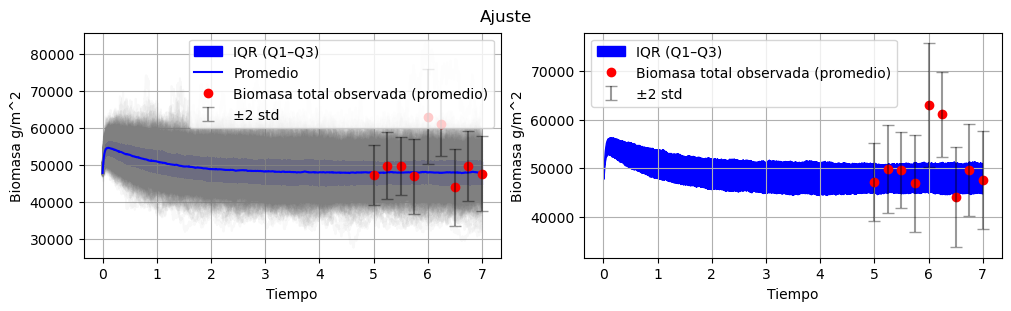

In [8]:
# Visualizacion del ajuste
idx =np.argmin(df2['costo'].values)
visualization(T, Dt, 1000, [rhoA, KA, estimates2[idx,0], estimates2[idx,1], rJ, sA, sJ], init_cond2, past_years = years_before)
print(f"Final estimation: mA = {estimates2[idx,0]} and mJ = {estimates2[idx,1]}")